In [124]:
# import of standard python libraries
import numpy as np
import os
import time
import corner
import astropy.io.fits as pyfits
import sys
import argparse
from tqdm import tqdm
import pandas as pd
import gc
#sys.path.insert(0, '../lenstronomy/lenstronomy/')
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.PointSource.point_source import PointSource
from lenstronomy.ImSim.image_model import ImageModel
import lenstronomy.Util.param_util as param_util
import lenstronomy.Util.simulation_util as sim_util
import lenstronomy.Util.image_util as image_util
from lenstronomy.Util import kernel_util
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF
# from deeplenstronomy.PopSim.population import *
# from deeplenstronomy.DataHandling.initital_data_settings import *
# from deeplenstronomy.ImSim.inject_simulations import *
# from deeplenstronomy.SkySurveyModel.sky_survey import *
# from deeplenstronomy.ImSim.image_sim import *


# lenstronomy module import
import lenstronomy.Util.data_util as data_util
import lenstronomy.Util.util as util
import lenstronomy.Plots.plot_util as plot_util
from lenstronomy.SimulationAPI.sim_api import SimAPI
from lenstronomy.LightModel.Profiles.gaussian import GaussianEllipse
from lenstronomy.LensModel.lens_model import LensModel

In [125]:
from lenstronomy.SimulationAPI.sim_api import SimAPI
data = pd.read_csv('merged_agn_lc.csv')
data


def mag_to_flux(m, mz):
    return 10**((mz - m)/2.5)

mag_g = mag_to_flux(data['mag_g'],27.5)
mag_r = mag_to_flux(data['mag_r'],27.5)
mag_i = mag_to_flux(data['mag_i'],27.5)
mag_z = mag_to_flux(data['mag_z'],27.5)


print(mag_g, mag_r, mag_i, mag_z)
# define lens configuration and cosmology (not for lens modelling)
z_lens = 0.6
z_source = 1.5
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Ob0=0.)



# data specifics
sigma_bkg = 10.0  #  background noise per pixel (Gaussian)
exp_time = 100.  #  exposure time (arbitrary units, flux per pixel is in units #photons/exp_time unit)
numPix = 100  #  cutout pixel size
deltaPix = 0.263  #  pixel size in arcsec (area per pixel = deltaPix**2)
fwhm = 1.0  # full width half max of PSF (only valid when psf_type='gaussian')
psf_type = 'GAUSSIAN'  # 'gaussian', 'pixel', 'NONE'
kernel_size = 91

# initial input simulation

# generate the coordinate grid and image properties
kwargs_data = sim_util.data_configure_simple(numPix, deltaPix, exp_time, sigma_bkg)
data_class = ImageData(**kwargs_data)
kwargs_psf = {'psf_type': 'GAUSSIAN', 'fwhm': fwhm, 'pixel_size': deltaPix, 'truncation': 3}
psf_class = PSF(**kwargs_psf)



# data specifics
sigma_bkg = 8.0  #  background noise per pixel (Gaussian)
exp_time = 100.  #  exposure time (arbitrary units, flux per pixel is in units #photons/exp_time unit)
numPix = 100  #  cutout pixel size
deltaPix = 0.263  #  pixel size in arcsec (area per pixel = deltaPix**2)
fwhm = 1.0  # full width half max of PSF (only valid when psf_type='gaussian')
psf_type = 'GAUSSIAN'  # 'gaussian', 'pixel', 'NONE'
kernel_size = 91

# initial input simulation

# generate the coordinate grid and image properties
kwargs_data = sim_util.data_configure_simple(numPix, deltaPix, exp_time, sigma_bkg)
data_class = ImageData(**kwargs_data)
kwargs_psf = {'psf_type': 'GAUSSIAN', 'fwhm': fwhm, 'pixel_size': deltaPix, 'truncation': 3}
psf_class = PSF(**kwargs_psf)

# quasar center (we chose a off-centered position)
center_x_1 = np.random.uniform(-0.03, 0.03)
center_y_1 = np.random.uniform(-0.03, 0.03)
center_x_2 = np.random.uniform(-4.3, 4.3)
center_y_2 = np.random.uniform(-4.3, 4.3)
center_x_list = [center_x_1, center_x_2]
center_y_list = [center_y_1, center_y_2]

# quasar brightness (as measured as the sum of pixel values)
point_amp_list = [mag_g[0], mag_g[6]]
from lenstronomy.PointSource.point_source import PointSource
point_source_list = ['UNLENSED']
pointSource = PointSource(point_source_type_list=point_source_list)
kwargs_ps = [{'ra_image': center_x_list, 'dec_image': center_y_list, 'point_amp': point_amp_list}]

# from lenstronomy.LightModel.light_model import LightModel
light_model_list = ['SERSIC_ELLIPSE', 'SERSIC']
lightModel = LightModel(light_model_list=light_model_list)
import lenstronomy.Util.param_util as param_util
e1, e2 = param_util.phi_q2_ellipticity(phi=0.3, q=0.6)
kwargs_disk = {'amp': 100, 'n_sersic': 1, 'R_sersic': 0.7, 'e1': e1, 'e2': e2, 'center_x': center_x, 'center_y': center_y}
kwargs_buldge = {'amp': 100, 'n_sersic': 4, 'R_sersic': 0.3, 'center_x': center_x, 'center_y': center_y}
kwargs_host = [kwargs_disk, kwargs_buldge]

0    393.786273
1    442.619576
2    360.827845
3    407.158901
4    473.461399
5    570.598417
6    576.653740
7    543.973838
8    527.577972
9    443.027013
Name: mag_g, dtype: float64 0    371.547676
1    343.162830
2    328.057100
3    350.622909
4    441.919350
5    460.670699
6    550.681478
7    488.829134
8    488.236290
9    542.256594
Name: mag_r, dtype: float64 0    348.086805
1    338.432875
2    405.765398
3    369.246685
4    377.774321
5    535.463995
6    565.961887
7    559.790302
8    541.592413
9    439.568722
Name: mag_i, dtype: float64 0    400.430120
1    521.020586
2    393.181973
3    360.479380
4    544.591158
5    504.141848
6    543.494748
7    564.181733
8    558.700556
9    491.755570
Name: mag_z, dtype: float64


simulation started
making progress


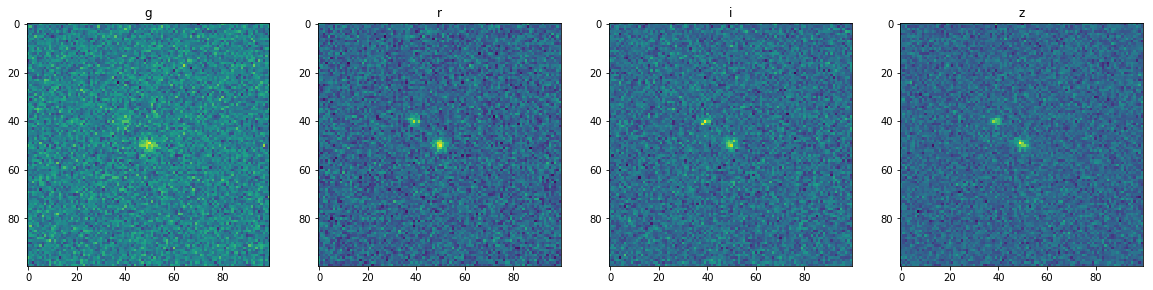

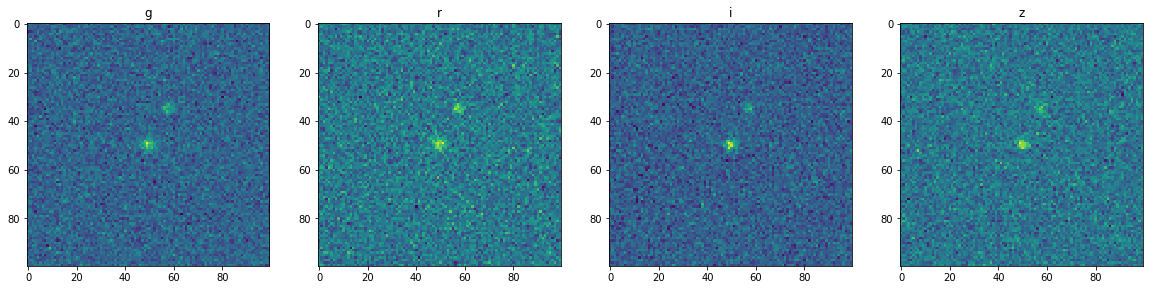

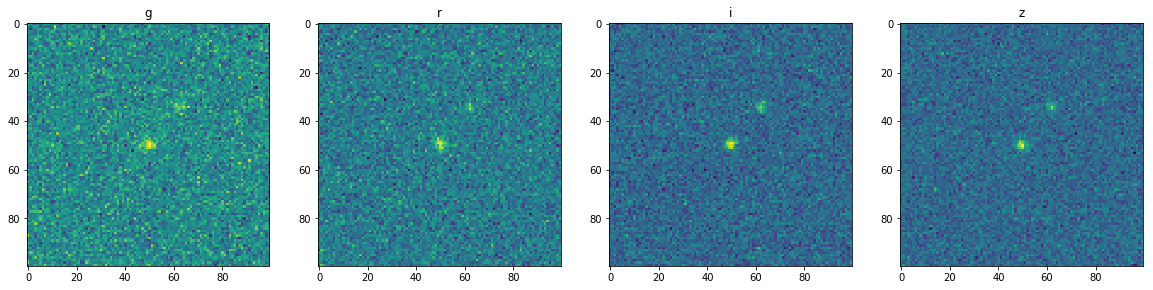

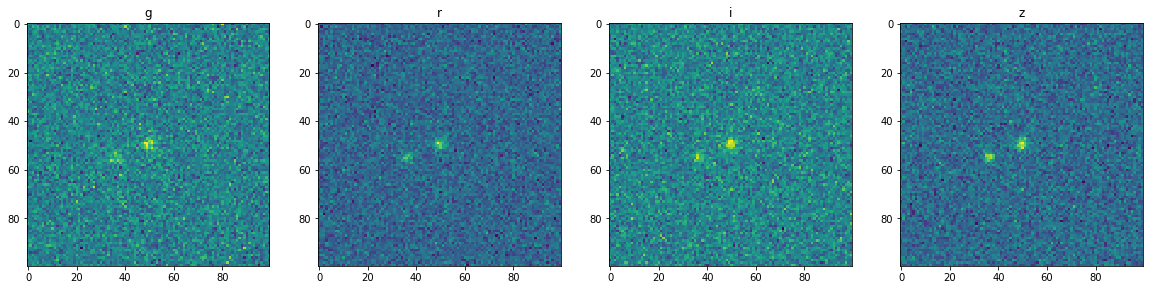

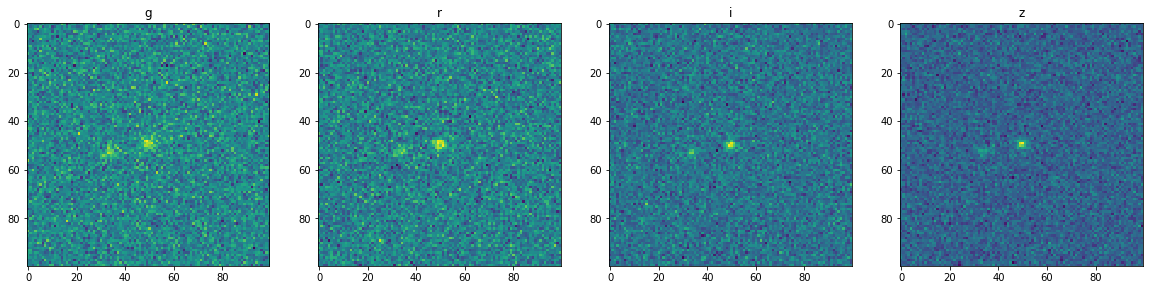

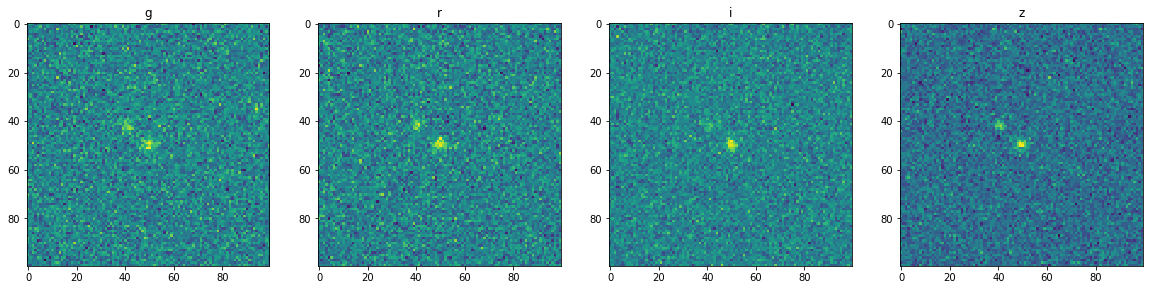

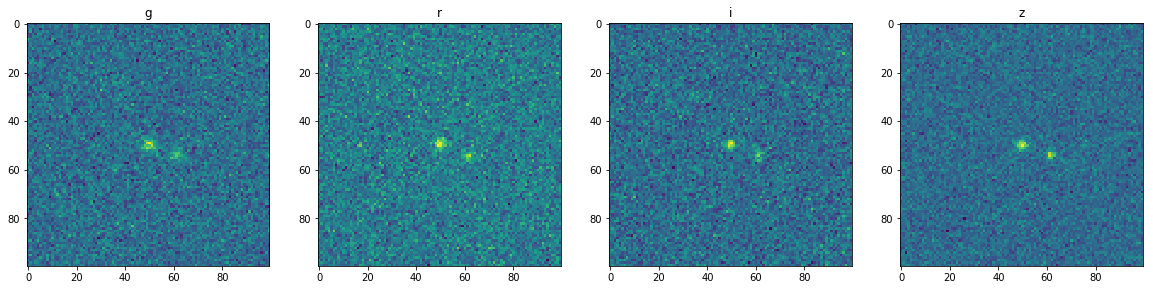

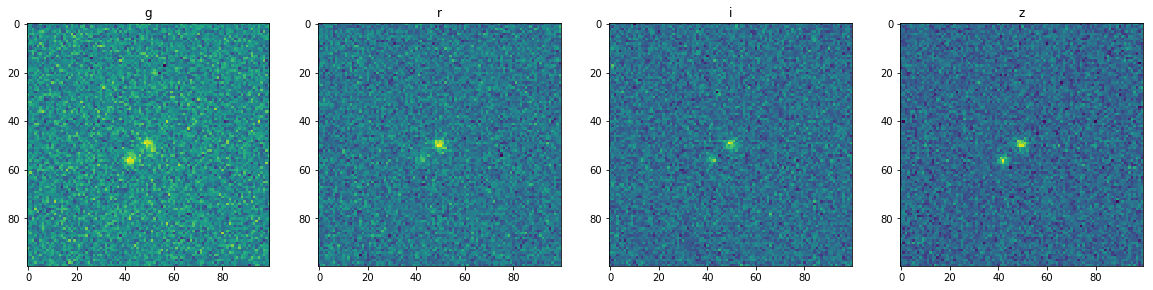

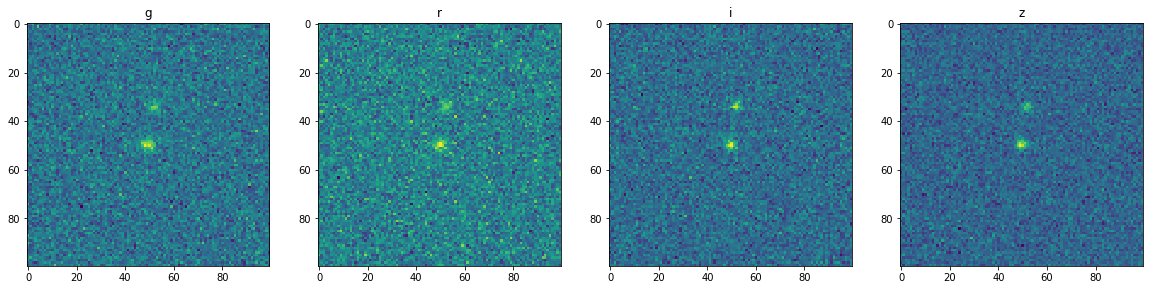

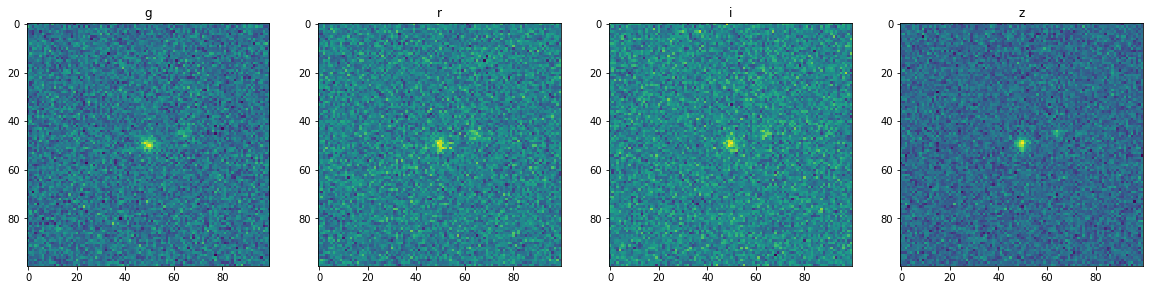

In [126]:
from lenstronomy.ImSim.image_model import ImageModel


if __name__ == "__main__":
    print("simulation started")
    show_img = True
    IsTrain = True #False
    num_samples = 10
    root_folder = "./non_lens_full_band/"
    if not os.path.exists(root_folder):
        os.mkdir(root_folder)

    if IsTrain:
        np.random.seed(12345)
        file_path = root_folder+"train/"
    else:
        np.random.seed(54321)
        file_path = root_folder+"test/"

    if not os.path.exists(file_path):
        os.mkdir(file_path)

    bands = ['g', 'r', 'i', 'z']

    for i in range(num_samples):
        if i % 200 ==0:
            print("making progress")
        full_band_images = np.zeros((numPix, numPix, 4))
        center_x_1 = np.random.uniform(-0.03, 0.03)
        center_y_1 = np.random.uniform(-0.03, 0.03)
        center_x_2 = np.random.uniform(-4.3, 4.3)
        center_y_2 = np.random.uniform(-4.3, 4.3)
        center_x_list = [center_x_1, center_x_2]
        center_y_list = [center_y_1, center_y_2]
        for color_idx, band in enumerate(bands):
            #### lensing quantities

            fwhm_list = [1.12, 0.96, 0.88, 0.84] # PSF median from arXiv:1708.01533

            if color_idx ==0:
                mag_agn = mag_g
            elif color_idx ==1:
                mag_agn = mag_r
            elif color_idx ==2:
                mag_agn = mag_i
            elif color_idx ==3:
                mag_agn = mag_z

            #### psf condition for different bands

            kwargs_data = sim_util.data_configure_simple(numPix, deltaPix, exp_time, sigma_bkg)
            data_class = ImageData(**kwargs_data)
            kwargs_psf = {'psf_type': psf_type, 'fwhm':fwhm_list[color_idx], 'pixel_size': deltaPix, 'truncation': 3}
            psf_class = PSF(**kwargs_psf)


            #### pick two agn magnitude from the catalog
            agn_seed_1 = np.random.randint(0, 9)
            agn_seed_2 = np.random.randint(0, 9)

            point_amp_list = [mag_agn[agn_seed_1], mag_agn[agn_seed_2]]
            kwargs_numerics = {'supersampling_factor': 1, 'supersampling_convolution': False}
            imageModel = ImageModel(data_class, psf_class, lens_light_model_class=lightModel,
                                        point_source_class=pointSource, kwargs_numerics=kwargs_numerics)

            point_source_list = ['UNLENSED']
            pointSource = PointSource(point_source_type_list=point_source_list)
            kwargs_ps = [{'ra_image': center_x_list, 'dec_image': center_y_list, 'point_amp': point_amp_list}]


            # generate image
            image_sim = imageModel.image(kwargs_lens_light=kwargs_host, kwargs_ps=kwargs_ps)
            poisson = image_util.add_poisson(image_sim, exp_time=exp_time)
            bkg = image_util.add_background(image_sim, sigma_bkd=sigma_bkg)
            image_sim = image_sim + bkg + poisson

            data_class.update_data(image_sim)
            kwargs_data['image_data'] = image_sim


            full_band_images[:, :, color_idx] += image_sim
            
        
        df = pd.DataFrame()
        df['name'] = "non_lens" + "_" + "%07d" % (i+1)
        #print(center_x_1)
        df['center_x_1'] = center_x_1
        df['center_x_2'] = center_x_2
        df['center_y_1'] = center_y_1
        df['center_y_2'] = center_y_2
        ### saving files
        np.save(file_path + "full_band_lens" + "_" + "%07d" % (i+1) + ".npy", full_band_images)
        
        
        
        if i > 0:
            df_podcast = pd.concat([df_podcast, df], axis =0).reset_index(drop=True)
        else:
            df_podcast = df
        
        
        if show_img:
            plt.figure(figsize=(20,10))
            plt.subplot(1, 4, 1)
            plt.imshow(full_band_images[:, :, 0])
            #plt.colorbar()
            plt.title("g")
            plt.subplot(1, 4, 2)
            plt.imshow(full_band_images[:, :, 1])
            plt.title("r")
            plt.subplot(1, 4, 3)
            plt.imshow(full_band_images[:, :, 2])
            plt.title("i")
            plt.subplot(1, 4, 4)
            plt.imshow(full_band_images[:, :, 3])
            plt.title("z")
            plt.show()
    df_podcast.to_csv(file_path + "non_lens_info.csv")


In [127]:
df_podcast

,name,center_x_1,center_x_2,center_y_1,center_y_2
